In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!eotdl version

EOTDL Version: 2025.06.27-2


# Base datasets

We start staging the [Massachusets Roads Datasets](https://www.eotdl.com/datasets/MassachusettsRoadsDataset).

In [3]:
# !eotdl datasets get MassachusettsRoadsDataset -a -p data

In [4]:
# !unzip data/MassachusettsRoadsDataset/massachussets.zip -d data

The dataset contains aerial images with associated road labels.

In [5]:
import os

train_image_dir = 'data/tiff/train'
val_image_dir = 'data/tiff/val'
test_image_dir = 'data/tiff/test'
train_mask_dir = 'data/tiff/train_labels'
val_mask_dir = 'data/tiff/val_labels'
test_mask_dir = 'data/tiff/test_labels'

train_images = os.listdir(train_image_dir)
val_images = os.listdir(val_image_dir)
test_images = os.listdir(test_image_dir)

train_images_paths = [os.path.join(train_image_dir, image) for image in train_images]
val_images_paths = [os.path.join(val_image_dir, image) for image in val_images]
test_images_paths = [os.path.join(test_image_dir, image) for image in test_images]
train_masks_paths = [os.path.join(train_mask_dir, image).replace('.tiff', '.tif') for image in train_images]
val_masks_paths = [os.path.join(val_mask_dir, image).replace('.tiff', '.tif') for image in val_images]
test_masks_paths = [os.path.join(test_mask_dir, image).replace('.tiff', '.tif') for image in test_images]

assert len(train_images_paths) == len(train_masks_paths)
assert len(test_images_paths) == len(test_masks_paths)
assert len(val_images_paths) == len(val_masks_paths)

train_images_paths[:3], train_masks_paths[:3]

(['data/tiff/train/27178705_15.tiff',
  'data/tiff/train/20578960_15.tiff',
  'data/tiff/train/20279005_15.tiff'],
 ['data/tiff/train_labels/27178705_15.tif',
  'data/tiff/train_labels/20578960_15.tif',
  'data/tiff/train_labels/20279005_15.tif'])

/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


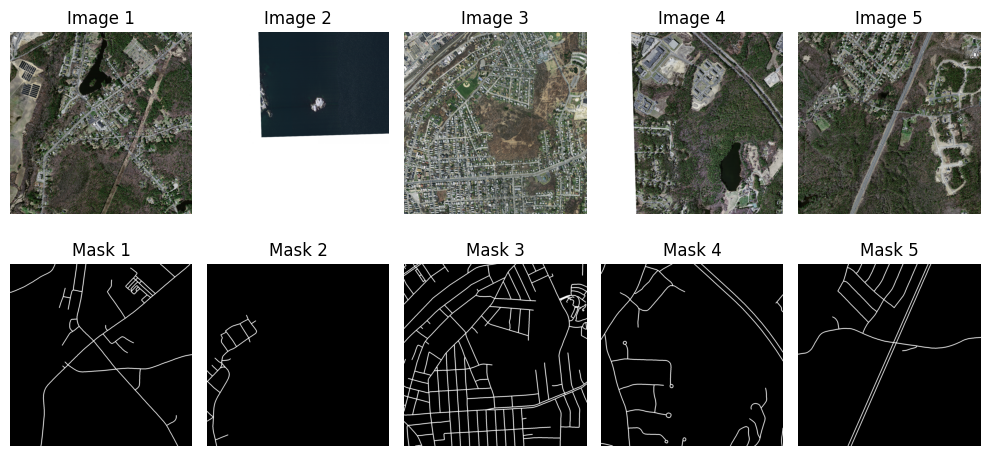

In [6]:
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
samples = 5
fig, axes = plt.subplots(2, samples, figsize=(2*samples, 5))
for i in range(samples):
    ix = np.random.randint(0, len(train_images_paths))
    x = rio.open(train_images_paths[ix]).read()
    y = rio.open(train_masks_paths[ix]).read()
    # Plot image
    axes[0, i].imshow(x.transpose(1, 2, 0))
    axes[0, i].set_title(f'Image {i+1}')
    axes[0, i].axis('off')
    # Plot mask
    axes[1, i].imshow(y[0], cmap='gray')
    axes[1, i].set_title(f'Mask {i+1}')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()


Each aerial image has a bounding box attached to it.

In [7]:
ds = rio.open(train_images_paths[0])

ds.bounds, ds.crs

(BoundingBox(left=270986.436, bottom=869771.0250000001, right=272486.436, top=871271.025),
 CRS.from_wkt('PROJCS["NAD83 / Massachusetts Mainland",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",41],PARAMETER["central_meridian",-71.5],PARAMETER["standard_parallel_1",42.6833333333333],PARAMETER["standard_parallel_2",41.7166666666667],PARAMETER["false_easting",200000],PARAMETER["false_northing",750000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26986"]]'))

We can use now this information to find and download matching Sentinel 2 images.

# Finding Sentinel 2 matches

First, we generate a list of bounding boxes from each aerial image.

In [8]:
import geopandas as gpd
from shapely.geometry import box

def generate_bbs(paths):
    bbs = [box(*rio.open(p).bounds) for p in paths]
    # need to convert to epsg:4326, otherwise this step is not needed
    gdf = gpd.GeoDataFrame({'bbs': bbs}, geometry='bbs', crs=rio.open(paths[0]).crs).to_crs(epsg=4326)
    return gdf.geometry.bounds.values.tolist()

train_bbs = generate_bbs(train_images_paths)
val_bbs = generate_bbs(val_images_paths)
test_bbs = generate_bbs(test_images_paths)


We don't know the date at which the aerial images were taken (documentation does not provide this information). So we will assume that the images were taken around summer 2020 (avoid snow and winter images), and use a 30 day time buffer to find matches with low cloud cover.

> Remember to login to EOTDL and accept the terms and conditions in your profile to use the data access functions. If you already had a Sentinel Hub account, you should use your existing credentials in environment variables.

In [9]:
from tqdm import tqdm
from eotdl.access import find_sentinel_matches_by_bb
import utils

def find_matches(bbs):
    matches = []
    for bb in tqdm(bbs):
        matches.append(find_sentinel_matches_by_bb(bb, '2020-08-01', 30))
    return matches

def find_matches_parallel(bbs):
    from concurrent.futures import ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=8) as pool:
        args = [(bb, '2020-08-01', 30) for bb in bbs]
        with tqdm(total=len(bbs)) as progress:
            futures = []
            for arg in args:
                future = pool.submit(utils._find_matches, arg) 
                future.add_done_callback(lambda p: progress.update())
                futures.append(future)
            results = []
            for future in futures:
                result = future.result()
                results.append(result)
    return results

train_matches = find_matches_parallel(train_bbs)
val_matches = find_matches_parallel(val_bbs)
test_matches = find_matches_parallel(test_bbs)

100%|██████████| 49/49 [00:01<00:00, 36.14it/s]


In [10]:
import pandas as pd

df = pd.DataFrame({
    'image': train_images + val_images + test_images,
    'matches': train_matches + val_matches + test_matches,
    'bbox': train_bbs + val_bbs + test_bbs,
    'split': ['train'] * len(train_images) + ['val'] * len(val_images) + ['test'] * len(test_images)
})
os.makedirs('outputs', exist_ok=True)
df.to_json('outputs/matches.json', index=False)
df.head()


,image,matches,bbox,split
0,27178705_15.tiff,[{'id': 'S2A_MSIL2A_20200812T153601_N0214_R111...,"[-70.64214856283095, 42.07499312915679, -70.62...",train
1,20578960_15.tiff,[{'id': 'S2A_MSIL2A_20200815T153911_N0214_R011...,"[-71.43951976435005, 42.30789573226851, -71.42...",train
2,20279005_15.tiff,[{'id': 'S2A_MSIL2A_20200815T153911_N0214_R011...,"[-71.47589118638476, 42.34842768252468, -71.45...",train
3,24329215_15.tiff,[{'id': 'S2A_MSIL2A_20200815T153911_N0214_R011...,"[-70.98281502094515, 42.536247218530576, -70.9...",train
4,10828645_15.tiff,[{'id': 'S2A_MSIL2A_20200815T153911_N0214_R011...,"[-72.61726223156114, 42.018870607465374, -72.5...",train


# Downloading Sentinel 2 images

Once we have the matches, we can filter and download the final Sentinel 2 images.

In this case, we will keep the match with lowest cloud cover.

In [11]:
matches = pd.read_json('outputs/matches.json')
matches.head()

,image,matches,bbox,split
0,27178705_15.tiff,[{'id': 'S2A_MSIL2A_20200812T153601_N0214_R111...,"[-70.6421485628, 42.0749931292, -70.623836544,...",train
1,20578960_15.tiff,[{'id': 'S2A_MSIL2A_20200815T153911_N0214_R011...,"[-71.4395197644, 42.3078957323, -71.4213095638...",train
2,20279005_15.tiff,[{'id': 'S2A_MSIL2A_20200815T153911_N0214_R011...,"[-71.4758911864, 42.3484276825, -71.4576770785...",train
3,24329215_15.tiff,[{'id': 'S2A_MSIL2A_20200815T153911_N0214_R011...,"[-70.9828150209, 42.5362472185, -70.9644414315...",train
4,10828645_15.tiff,[{'id': 'S2A_MSIL2A_20200815T153911_N0214_R011...,"[-72.6172622316, 42.0188706075, -72.5989157694...",train


In [12]:
lowest_cloud_cover_matches = []
for ix, row in matches.iterrows():
    _matches = row['matches']
    lowest_cloud_cover = min(_matches, key=lambda x: x['properties']['eo:cloud_cover'])
    lowest_cloud_cover_matches.append(lowest_cloud_cover)

matches['lowest_cloud_cover_match'] = lowest_cloud_cover_matches
matches['cloud_cover'] = [match['properties']['eo:cloud_cover'] for match in matches['lowest_cloud_cover_match']]
matches['date'] = [match['properties']['datetime'].split('T')[0] for match in matches['lowest_cloud_cover_match']]
matches.to_json('outputs/matches_filtered.json', index=False)
matches.head()


,image,matches,bbox,split,lowest_cloud_cover_match,cloud_cover,date
0,27178705_15.tiff,[{'id': 'S2A_MSIL2A_20200812T153601_N0214_R111...,"[-70.6421485628, 42.0749931292, -70.623836544,...",train,{'id': 'S2B_MSIL2A_20200718T153559_N0214_R111_...,0.28,2020-07-18
1,20578960_15.tiff,[{'id': 'S2A_MSIL2A_20200815T153911_N0214_R011...,"[-71.4395197644, 42.3078957323, -71.4213095638...",train,{'id': 'S2B_MSIL2A_20200718T153559_N0214_R111_...,0.28,2020-07-18
2,20279005_15.tiff,[{'id': 'S2A_MSIL2A_20200815T153911_N0214_R011...,"[-71.4758911864, 42.3484276825, -71.4576770785...",train,{'id': 'S2B_MSIL2A_20200718T153559_N0214_R111_...,0.28,2020-07-18
3,24329215_15.tiff,[{'id': 'S2A_MSIL2A_20200815T153911_N0214_R011...,"[-70.9828150209, 42.5362472185, -70.9644414315...",train,{'id': 'S2B_MSIL2A_20200718T153559_N0214_R111_...,0.01,2020-07-18
4,10828645_15.tiff,[{'id': 'S2A_MSIL2A_20200815T153911_N0214_R011...,"[-72.6172622316, 42.0188706075, -72.5989157694...",train,{'id': 'S2A_MSIL2A_20200726T153911_N0214_R011_...,2.26,2020-07-26


In [13]:
matches['cloud_cover'].describe()

count    1171.000000
mean        0.893843
std         0.955738
min         0.010000
25%         0.010000
50%         0.280000
75%         1.450000
max         2.500000
Name: cloud_cover, dtype: float64

Now we can download the Sentinel 2 images.

In [15]:
from eotdl.access import download_sentinel_imagery

os.makedirs('outputs/tiff/train_s2', exist_ok=True)
os.makedirs('outputs/tiff/val_s2', exist_ok=True)
os.makedirs('outputs/tiff/test_s2', exist_ok=True)

def download_images(df):
    for ix, row in tqdm(df.iterrows(), total=len(df)):
        download_sentinel_imagery(
            f"outputs/tiff/{row['split']}_s2", 
            row['date'], 
            row['bbox'], 
            'sentinel-2-l2a',
            name=row['image'].split('.tiff')[0]
        )


def download_images_parallel(df):
    from concurrent.futures import ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=8) as pool:
        args = [tuple([
            f"outputs/tiff/{row['split']}_s2",
            row['date'],
            row['bbox'],
            'sentinel-2-l2a',
            row['image'].split('.tiff')[0]
        ]) for ix, row in df.iterrows()]
        with tqdm(total=len(args)) as progress:
            futures = []
            for arg in args:
                future = pool.submit(utils._download_sentinel_imagery, arg) # enviamos la tupla de argumentos
                future.add_done_callback(lambda p: progress.update())
                futures.append(future)
            results = []
            for future in futures:
                result = future.result()
                results.append(result)


# uncomment to download the images

download_images_parallel(matches)

100%|██████████| 1171/1171 [01:52<00:00, 10.42it/s]


In [16]:
import glob
import os

def cleanup(dir):
    json_files = glob.glob(f'{dir}/*.json')
    for json_file in json_files:
        os.remove(json_file)

cleanup('outputs/tiff/train_s2')
cleanup('outputs/tiff/val_s2')
cleanup('outputs/tiff/test_s2')

In [17]:
def check(dir, images):
    for image in images:
        assert os.path.exists(f'{dir}/{image}')

check('outputs/tiff/train_s2', train_images)
check('outputs/tiff/val_s2', val_images)
check('outputs/tiff/test_s2', test_images)

And visualize some examples.

In [18]:
train_s2_dir = 'outputs/tiff/train_s2'
val_s2_dir = 'outputs/tiff/val_s2'
test_s2_dir = 'outputs/tiff/test_s2'

train_s2_paths = [os.path.join(train_s2_dir, image) for image in train_images]
val_s2_paths = [os.path.join(val_s2_dir, image) for image in val_images]
test_s2_paths = [os.path.join(test_s2_dir, image) for image in test_images]


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-rela

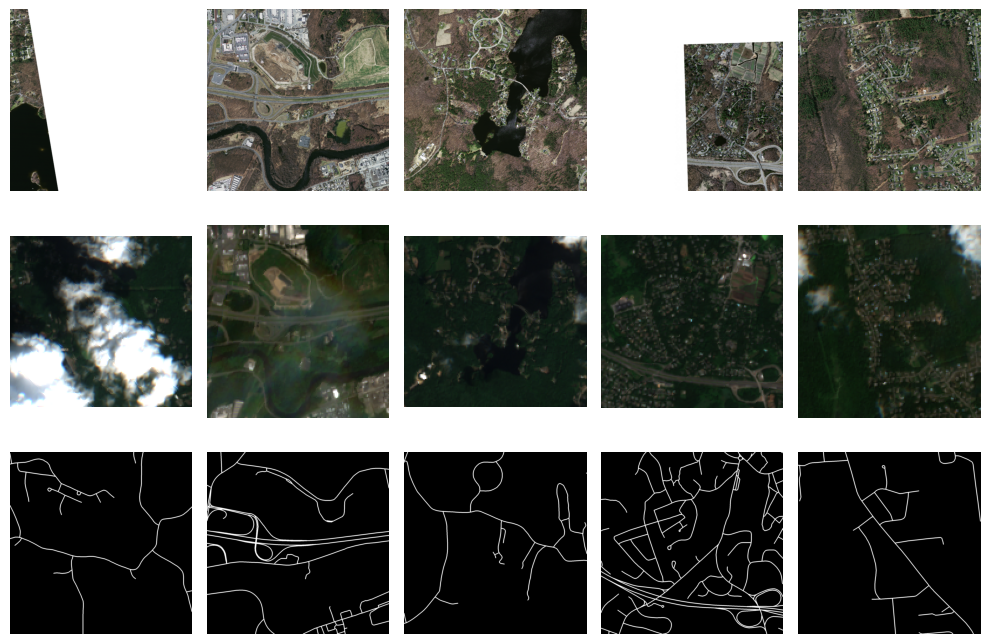

In [19]:
samples = 5
fig, axes = plt.subplots(3, samples, figsize=(2*samples, 7))
for i in range(samples):
    ix = np.random.randint(0, len(train_images_paths))
    x = rio.open(train_images_paths[ix]).read()
    s2 = np.clip(rio.open(train_s2_paths[ix]).read((4,3,2)) / 4000, 0, 1)
    y = rio.open(train_masks_paths[ix]).read()
    # Plot original image
    axes[0, i].imshow(x.transpose(1, 2, 0))
    axes[0, i].axis('off')
    # Plot Sentinel-2 image
    axes[1, i].imshow(s2.transpose(1, 2, 0))
    axes[1, i].axis('off')
    # Plot mask
    axes[2, i].imshow(y[0], cmap='gray')
    axes[2, i].axis('off')
plt.tight_layout()
plt.show()

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


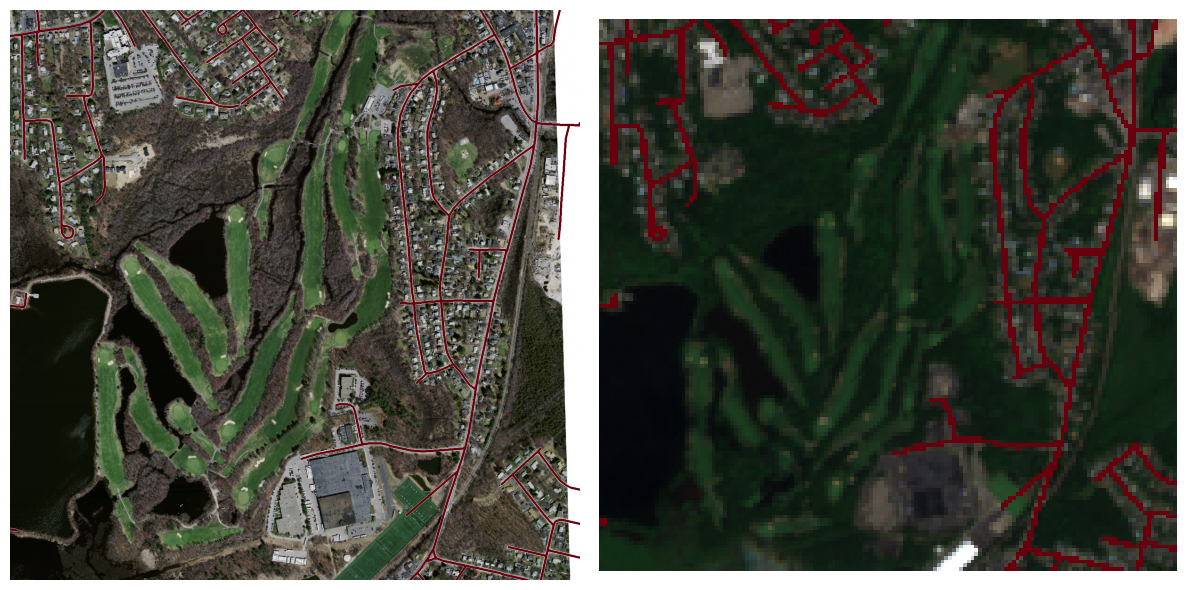

In [20]:
from skimage.transform import resize

# Select a random sample
ix = np.random.randint(0, len(train_images_paths))
x = rio.open(train_images_paths[ix]).read()
s2 = np.clip(rio.open(train_s2_paths[ix]).read((4,3,2)) / 4000, 0, 1)
y = rio.open(train_masks_paths[ix]).read()

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

mask = y[0] / 255.0  # Normalize to 0-1

# Plot original image
axes[0].imshow(x.transpose(1, 2, 0))
axes[0].imshow(mask, alpha=mask, cmap='Reds', vmin=0, vmax=1)
axes[0].axis('off')

# Plot Sentinel-2 image
axes[1].imshow(s2.transpose(1, 2, 0))
mask_resized = (resize(mask, (s2.shape[1], s2.shape[2]), order=0, preserve_range=True) > 0.2).astype(float)
axes[1].imshow(mask_resized, alpha=mask_resized, cmap='Reds', vmin=0, vmax=1)
axes[1].axis('off')

plt.tight_layout()
plt.show()


# Resizing masks

Since the Sentinel-2 images have a different resolution than the aerial images, we need to resize the masks to match the Sentinel-2 image resolution.

In [21]:
os.makedirs('outputs/tiff/train_s2_labels', exist_ok=True)
os.makedirs('outputs/tiff/val_s2_labels', exist_ok=True)
os.makedirs('outputs/tiff/test_s2_labels', exist_ok=True)

for ix, row in tqdm(matches.iterrows(), total=len(matches)):
    s2 = rio.open(f"outputs/tiff/{row['split']}_s2/{row['image']}")
    mask = rio.open(f"data/tiff/{row['split']}_labels/{row['image'].replace('.tiff', '.tif')}").read() / 255.0
    mask_resized = (resize(mask[0], (s2.shape[0], s2.shape[1]), order=0, preserve_range=True) > 0.2).astype(np.uint8) * 255
    dst_meta = s2.meta.copy()
    dst_meta.update(
        driver='GTiff',
        count=1,
        dtype=mask_resized.dtype,
        height=mask_resized.shape[0],
        width=mask_resized.shape[1],
        transform=s2.transform,
        crs=s2.crs
    )
    with rio.open(f"outputs/tiff/{row['split']}_s2_labels/{row['image'].replace('.tiff', '.tif')}", 'w', **dst_meta) as dst:
        dst.write(mask_resized[np.newaxis, ...])

100%|██████████| 1171/1171 [01:03<00:00, 18.32it/s]


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


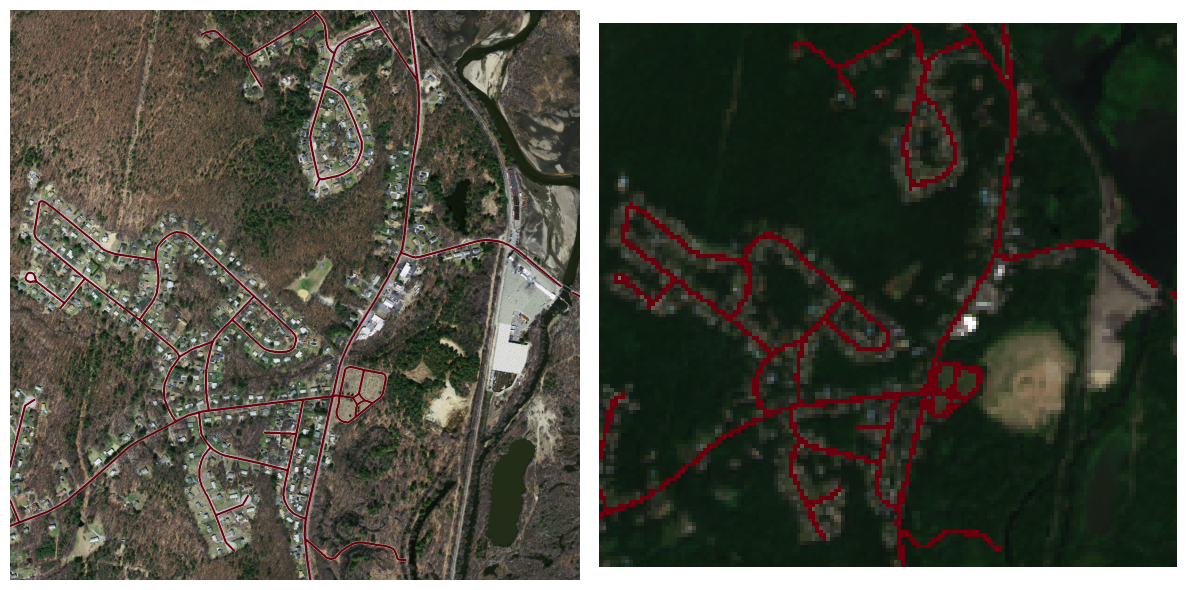

In [22]:
# Select a random sample
ix = np.random.randint(0, len(train_images_paths))
x = rio.open(train_images_paths[ix]).read()
s2 = np.clip(rio.open(train_s2_paths[ix]).read((4,3,2)) / 4000, 0, 1)
y = rio.open(train_masks_paths[ix]).read()
s2_y = rio.open(f"outputs/tiff/train_s2_labels/{train_images[ix].replace('.tiff', '.tif')}").read(1) / 255.0

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
mask = y[0] / 255.0  
# Plot original image
axes[0].imshow(x.transpose(1, 2, 0))
axes[0].imshow(mask, alpha=mask, cmap='Reds', vmin=0, vmax=1)
axes[0].axis('off')
# Plot Sentinel-2 image
axes[1].imshow(s2.transpose(1, 2, 0))
mask_resized = (resize(mask, (s2.shape[1], s2.shape[2]), order=0, preserve_range=True) > 0.2).astype(float)
axes[1].imshow(s2_y, alpha=s2_y, cmap='Reds', vmin=0, vmax=1)
axes[1].axis('off')

plt.tight_layout()
plt.show()

The dataset can be now ingested into EOTDL, which you can find at https://www.eotdl.com/datasets/MassachusettsRoadsS2